In [ ]:
import zipfile
import os
from shutil import copy2
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
zip_path = '/content/drive/MyDrive/archive (1).zip'
extract_path = '/content/dataset'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
data_path = '/content/dataset/raw-img'
classes = [folder for folder in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, folder))]
print("Sınıflar:", classes)

Sınıflar: ['ragno', 'pecora', 'cane', 'elefante', 'gatto', 'scoiattolo', 'cavallo', 'gallina', 'farfalla', 'mucca']


In [ ]:

train_path = '/content/split/train'
valid_path = '/content/split/valid'
test_path = '/content/split/test'


for split in [train_path, valid_path, test_path]:
    for cls in classes:
        os.makedirs(os.path.join(split, cls), exist_ok=True)


for cls in classes:
    class_dir = os.path.join(data_path, cls)
    images = os.listdir(class_dir)
    train_images, test_images = train_test_split(images, test_size=20, random_state=42)
    valid_images, test_images = train_test_split(test_images, test_size=10, random_state=42)
    train_images = train_images[:50]


    for image in train_images:
        copy2(os.path.join(class_dir, image), os.path.join(train_path, cls))
    for image in valid_images:
        copy2(os.path.join(class_dir, image), os.path.join(valid_path, cls))
    for image in test_images:
        copy2(os.path.join(class_dir, image), os.path.join(test_path, cls))

# Part 1

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = datasets.ImageFolder(root='/content/split/train', transform=transform)
valid_dataset = datasets.ImageFolder(root='/content/split/valid', transform=transform)
test_dataset = datasets.ImageFolder(root='/content/split/test', transform=transform)

In [ ]:
print("Size of train split: ",len(train_dataset))
print("Size of valid split: ",len(valid_dataset))
print("Size of test split: ",len(test_dataset))

Size of train split:  500
Size of valid split:  100
Size of test split:  100


In [ ]:
class AnimalClassifierWithouthDropout(nn.Module):
    def __init__(self, input_size=(128, 128)):
        super(AnimalClassifierWithouthDropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()


        out_size = self.calc_output_size(input_size[0])
        self.fc1 = nn.Linear(256 * out_size * out_size, 512)
        self.fc2 = nn.Linear(512, 10)

    def calc_output_size(self, size):
        for _ in range(2):
            size = (size - 3 + 2 * 1) // 1 + 1
            size = (size - 2) // 2 + 1
        return size

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.relu(self.bn6(self.conv6(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
def train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs):
    model.to(device)
    best_accuracy = 0
    best_model = None
    training_losses = []
    training_accuracies = []
    validation_losses = []
    validation_accuracies = []

    for epoch in range(num_epochs):
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

        model.train()
        running_loss = 0.0
        running_accuracy = 0.0
        total_samples = 0

        epoch_loss = 0.0
        epoch_accuracy = 0.0
        total_batches = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            running_accuracy += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            total_batches += 1

        epoch_loss = running_loss / total_batches
        epoch_accuracy = running_accuracy / total_samples
        training_losses.append(epoch_loss)
        training_accuracies.append(epoch_accuracy)
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.4f}")


        model.eval()
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct_valid += (predicted == labels).sum().item()
                total_valid += labels.size(0)

        val_loss = valid_loss / len(valid_loader)
        validation_losses.append(val_loss)
        val_accuracy = correct_valid / total_valid
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        validation_accuracies.append(val_accuracy)

        if val_accuracy> best_accuracy:
            best_accuracy = val_accuracy
            best_model = model.state_dict()
            best_params = {'batch_size': batch_size, 'learning_rate': lr, 'epoch': epoch}

    return best_model, best_accuracy, training_losses, training_accuracies, validation_losses, validation_accuracies,best_params


Starting training with Batch Size: 16, Learning Rate: 0.001
Epoch 1/100, Training Loss: 43.9845, Training Accuracy: 0.1460
Validation Loss: 4.7368, Validation Accuracy: 0.1500
Epoch 2/100, Training Loss: 2.8079, Training Accuracy: 0.1760
Validation Loss: 2.4117, Validation Accuracy: 0.1400
Epoch 3/100, Training Loss: 2.1948, Training Accuracy: 0.1760
Validation Loss: 2.6376, Validation Accuracy: 0.1000
Epoch 4/100, Training Loss: 2.0200, Training Accuracy: 0.2440
Validation Loss: 2.7633, Validation Accuracy: 0.1100
Epoch 5/100, Training Loss: 1.8896, Training Accuracy: 0.3200
Validation Loss: 2.8993, Validation Accuracy: 0.1600
Epoch 6/100, Training Loss: 1.7726, Training Accuracy: 0.3940
Validation Loss: 2.7816, Validation Accuracy: 0.1500
Epoch 7/100, Training Loss: 1.5894, Training Accuracy: 0.4480
Validation Loss: 3.0461, Validation Accuracy: 0.1700
Epoch 8/100, Training Loss: 1.4203, Training Accuracy: 0.4820
Validation Loss: 3.2675, Validation Accuracy: 0.1800
Epoch 9/100, Traini

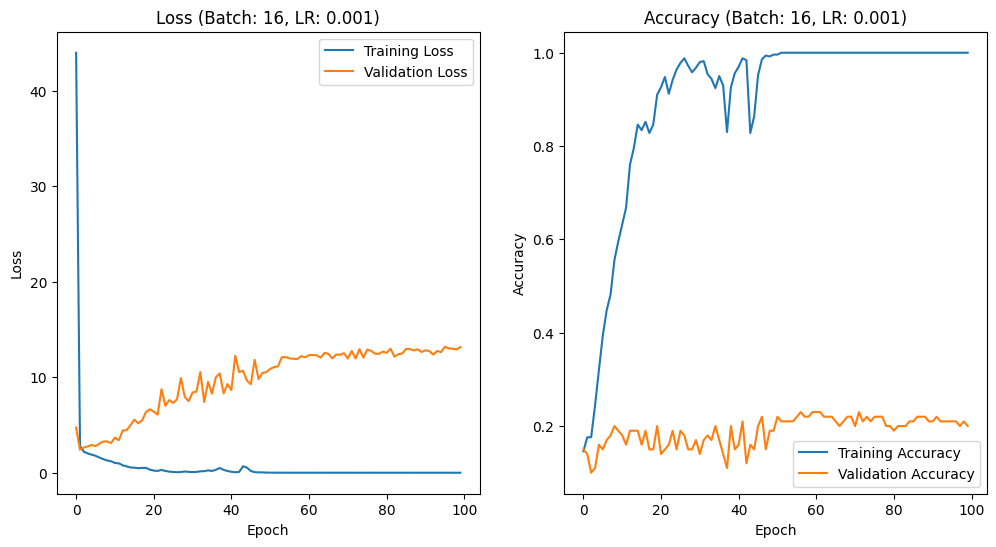

Starting training with Batch Size: 16, Learning Rate: 0.01
Epoch 1/100, Training Loss: 278.0697, Training Accuracy: 0.0980
Validation Loss: 3.3895, Validation Accuracy: 0.1000
Epoch 2/100, Training Loss: 2.3136, Training Accuracy: 0.0740
Validation Loss: 2.3195, Validation Accuracy: 0.1000
Epoch 3/100, Training Loss: 2.2997, Training Accuracy: 0.1000
Validation Loss: 3.3389, Validation Accuracy: 0.1000
Epoch 4/100, Training Loss: 2.3558, Training Accuracy: 0.1000
Validation Loss: 2.3316, Validation Accuracy: 0.1000
Epoch 5/100, Training Loss: 2.3217, Training Accuracy: 0.0720
Validation Loss: 2.3017, Validation Accuracy: 0.1000
Epoch 6/100, Training Loss: 2.3037, Training Accuracy: 0.0880
Validation Loss: 2.3004, Validation Accuracy: 0.1000
Epoch 7/100, Training Loss: 2.3047, Training Accuracy: 0.0820
Validation Loss: 2.3001, Validation Accuracy: 0.1000
Epoch 8/100, Training Loss: 2.3048, Training Accuracy: 0.0980
Validation Loss: 2.2989, Validation Accuracy: 0.1000
Epoch 9/100, Traini

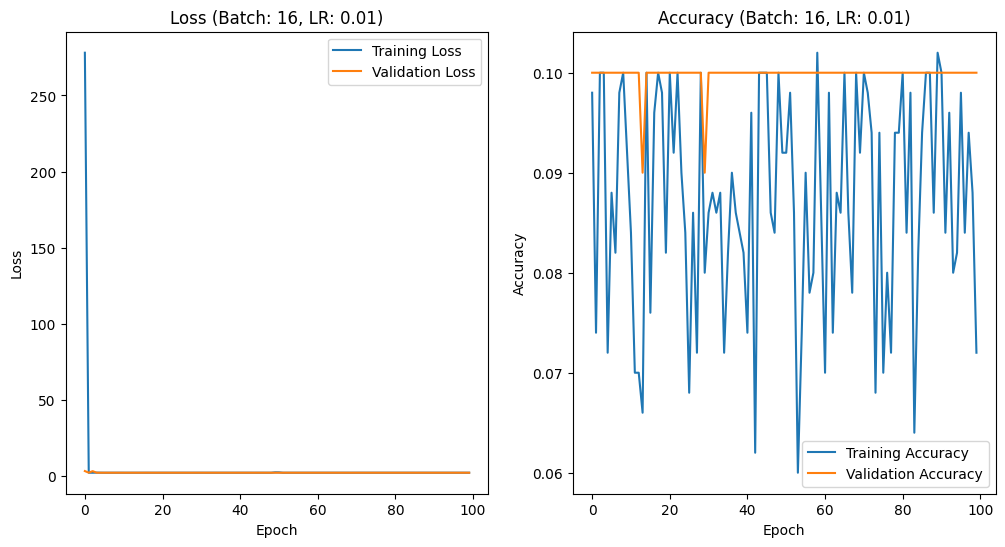

Starting training with Batch Size: 32, Learning Rate: 0.001
Epoch 1/100, Training Loss: 45.9944, Training Accuracy: 0.1300
Validation Loss: 32.4594, Validation Accuracy: 0.1000
Epoch 2/100, Training Loss: 13.2000, Training Accuracy: 0.1460
Validation Loss: 9.7712, Validation Accuracy: 0.1200
Epoch 3/100, Training Loss: 4.4595, Training Accuracy: 0.1120
Validation Loss: 2.8475, Validation Accuracy: 0.1400
Epoch 4/100, Training Loss: 2.5998, Training Accuracy: 0.1400
Validation Loss: 2.4431, Validation Accuracy: 0.1000
Epoch 5/100, Training Loss: 2.2173, Training Accuracy: 0.1500
Validation Loss: 2.4822, Validation Accuracy: 0.0800
Epoch 6/100, Training Loss: 2.2098, Training Accuracy: 0.1440
Validation Loss: 2.4973, Validation Accuracy: 0.0900
Epoch 7/100, Training Loss: 2.1657, Training Accuracy: 0.1660
Validation Loss: 2.5761, Validation Accuracy: 0.0900
Epoch 8/100, Training Loss: 2.1505, Training Accuracy: 0.1600
Validation Loss: 2.5590, Validation Accuracy: 0.1100
Epoch 9/100, Trai

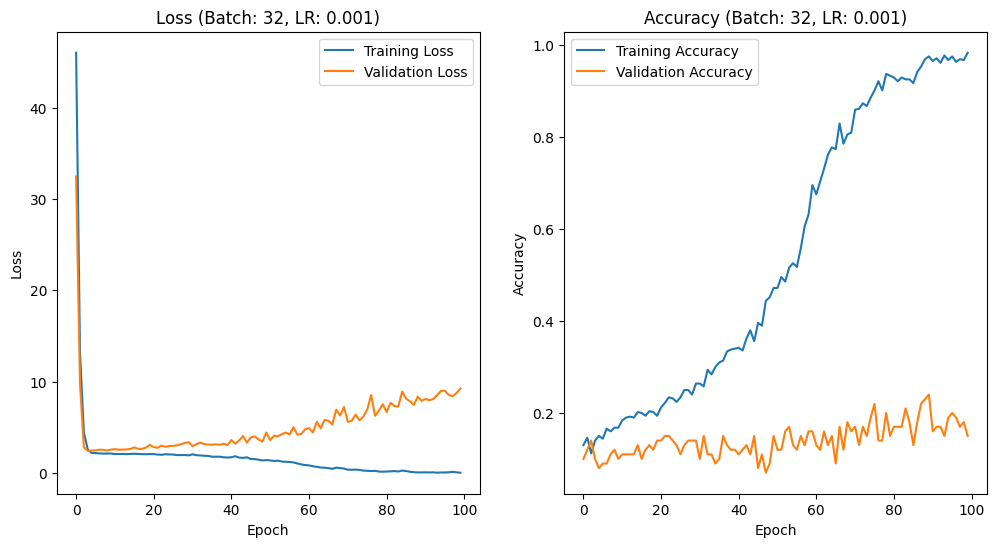

Starting training with Batch Size: 32, Learning Rate: 0.01
Epoch 1/100, Training Loss: 497.4797, Training Accuracy: 0.1240
Validation Loss: 15350.4741, Validation Accuracy: 0.1000
Epoch 2/100, Training Loss: 90.7961, Training Accuracy: 0.1620
Validation Loss: 168.2945, Validation Accuracy: 0.1200
Epoch 3/100, Training Loss: 10.5023, Training Accuracy: 0.1320
Validation Loss: 25.5925, Validation Accuracy: 0.0800
Epoch 4/100, Training Loss: 6.2048, Training Accuracy: 0.1420
Validation Loss: 2.2882, Validation Accuracy: 0.1100
Epoch 5/100, Training Loss: 2.5452, Training Accuracy: 0.1180
Validation Loss: 2.2580, Validation Accuracy: 0.1100
Epoch 6/100, Training Loss: 2.2928, Training Accuracy: 0.1140
Validation Loss: 2.2703, Validation Accuracy: 0.1200
Epoch 7/100, Training Loss: 2.2799, Training Accuracy: 0.1120
Validation Loss: 2.2728, Validation Accuracy: 0.1100
Epoch 8/100, Training Loss: 2.2694, Training Accuracy: 0.1140
Validation Loss: 2.2736, Validation Accuracy: 0.1100
Epoch 9/10

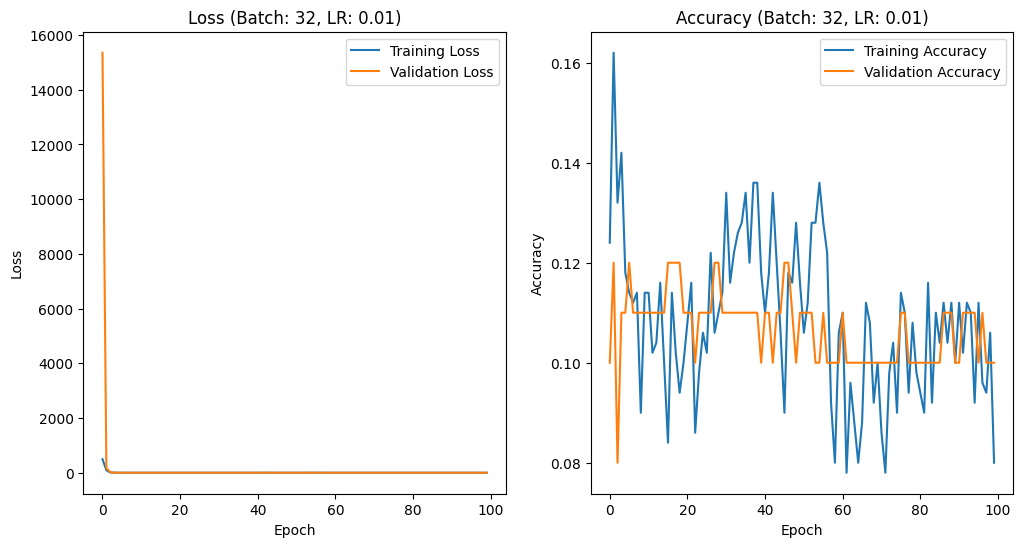

Starting training with Batch Size: 64, Learning Rate: 0.001
Epoch 1/100, Training Loss: 72.8245, Training Accuracy: 0.1240
Validation Loss: 19.8126, Validation Accuracy: 0.1000
Epoch 2/100, Training Loss: 26.7314, Training Accuracy: 0.0900
Validation Loss: 5.6943, Validation Accuracy: 0.1100
Epoch 3/100, Training Loss: 6.7129, Training Accuracy: 0.1280
Validation Loss: 2.7965, Validation Accuracy: 0.1100
Epoch 4/100, Training Loss: 2.5281, Training Accuracy: 0.1220
Validation Loss: 2.4804, Validation Accuracy: 0.0900
Epoch 5/100, Training Loss: 2.2465, Training Accuracy: 0.1320
Validation Loss: 2.3749, Validation Accuracy: 0.0700
Epoch 6/100, Training Loss: 2.2602, Training Accuracy: 0.1220
Validation Loss: 2.3104, Validation Accuracy: 0.0900
Epoch 7/100, Training Loss: 2.2351, Training Accuracy: 0.1440
Validation Loss: 2.3646, Validation Accuracy: 0.1200
Epoch 8/100, Training Loss: 2.1856, Training Accuracy: 0.1700
Validation Loss: 2.3411, Validation Accuracy: 0.1000
Epoch 9/100, Trai

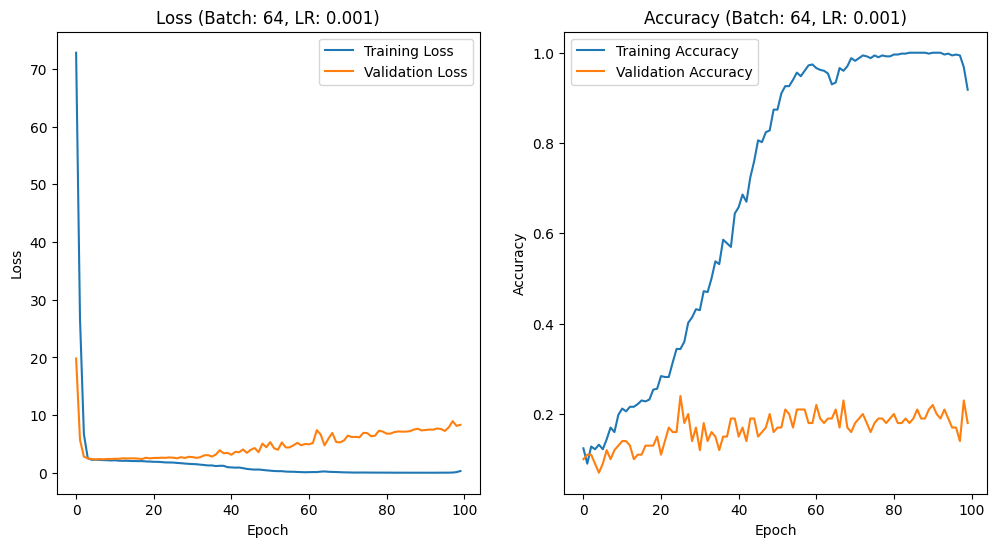

Starting training with Batch Size: 64, Learning Rate: 0.01
Epoch 1/100, Training Loss: 938.0445, Training Accuracy: 0.1080
Validation Loss: 64766.0000, Validation Accuracy: 0.1000
Epoch 2/100, Training Loss: 310.7483, Training Accuracy: 0.1280
Validation Loss: 1559.5095, Validation Accuracy: 0.0900
Epoch 3/100, Training Loss: 14.7456, Training Accuracy: 0.1200
Validation Loss: 30.3511, Validation Accuracy: 0.1200
Epoch 4/100, Training Loss: 3.1218, Training Accuracy: 0.1600
Validation Loss: 5.5465, Validation Accuracy: 0.1400
Epoch 5/100, Training Loss: 2.3299, Training Accuracy: 0.1380
Validation Loss: 2.9008, Validation Accuracy: 0.1500
Epoch 6/100, Training Loss: 2.4066, Training Accuracy: 0.1440
Validation Loss: 2.4493, Validation Accuracy: 0.1300
Epoch 7/100, Training Loss: 2.2205, Training Accuracy: 0.1560
Validation Loss: 2.3033, Validation Accuracy: 0.1400
Epoch 8/100, Training Loss: 2.3989, Training Accuracy: 0.1740
Validation Loss: 2.3281, Validation Accuracy: 0.1000
Epoch 9/

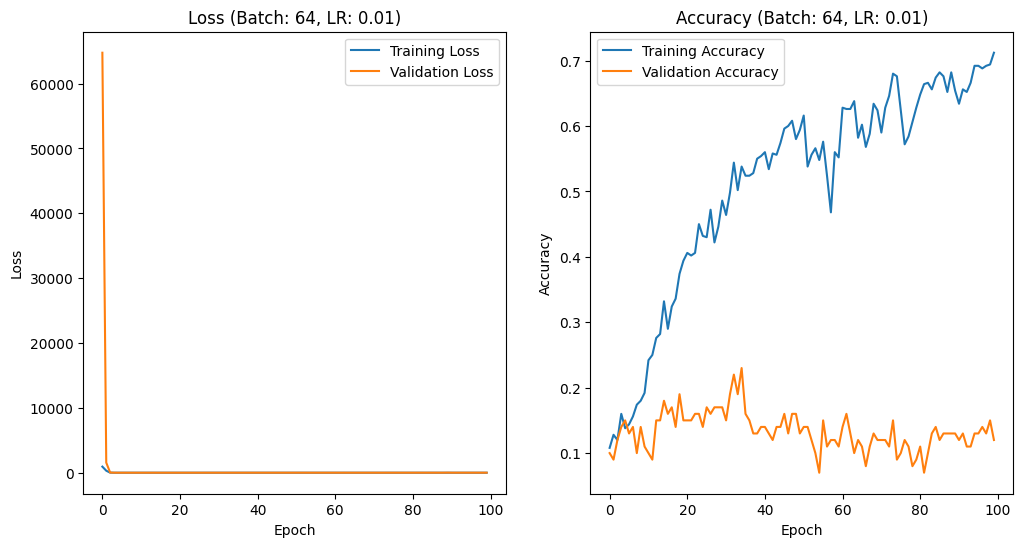

In [ ]:
import matplotlib.pyplot as plt

batch_sizes = [16, 32, 64]
learning_rates = [0.001, 0.01]
num_epochs = 100

best_model_info = {}
best_accuracy = 0

for batch_size in batch_sizes:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    for lr in learning_rates:
        print(f"Starting training with Batch Size: {batch_size}, Learning Rate: {lr}")
        model = AnimalClassifierWithouthDropout().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        best_model, val_accuracy, training_losses, training_accuracies, validation_losses, validation_accuracies, best_params = train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs)

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_info = {
                'state_dict': best_model,
                'accuracy': val_accuracy,
                'params': best_params
            }


        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(training_losses, label='Training Loss')
        plt.plot(validation_losses, label='Validation Loss')
        plt.title(f'Loss (Batch: {batch_size}, LR: {lr})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()


        plt.subplot(1, 2, 2)
        plt.plot(training_accuracies, label='Training Accuracy')
        plt.plot(validation_accuracies, label='Validation Accuracy')
        plt.title(f'Accuracy (Batch: {batch_size}, LR: {lr})')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

In [ ]:
print("Best Model Information:", best_model_info)

Best Model Information: {'state_dict': OrderedDict([('conv1.weight', tensor([[[[-1.3405e-01, -1.5537e-01, -8.1284e-02],
          [ 1.7501e-01,  6.6599e-02,  1.7112e-01],
          [-6.6802e-02, -2.5227e-02,  8.1553e-02]],

         [[ 1.1838e-01,  1.6596e-01,  1.9332e-02],
          [ 1.6589e-01, -3.0517e-03, -1.5492e-01],
          [-1.5833e-01, -7.6661e-02, -2.3300e-03]],

         [[ 1.5971e-01, -1.7764e-01, -6.6249e-02],
          [-4.0298e-03,  1.9049e-01,  1.9311e-01],
          [-9.4664e-02, -3.0046e-03, -6.5119e-02]]],


        [[[-4.8894e-02,  6.4350e-02, -1.7131e-01],
          [ 1.2230e-01, -1.3871e-01,  5.5562e-03],
          [-1.0402e-01,  1.5148e-01,  1.7966e-01]],

         [[-6.3721e-02, -2.8495e-02,  1.2479e-01],
          [ 1.2219e-01,  8.0506e-03,  1.9423e-02],
          [-1.6673e-01, -1.4566e-01,  4.4366e-02]],

         [[-8.6787e-02, -5.9507e-02, -1.8351e-01],
          [ 1.1131e-01, -8.9987e-02, -1.3983e-01],
          [ 4.7399e-02,  1.7306e-01, -1.4472e-01]]],

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=best_model_info['params']['batch_size'], shuffle=False)

In [ ]:
final_model = AnimalClassifierWithouthDropout()
final_model.load_state_dict(best_model_info['state_dict'])
final_model.to(device)
final_model.eval()

AnimalClassifierNoDropout(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
with torch.no_grad():
    total_correct = 0
    total_samples = 0

    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = final_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    test_accuracy = total_correct / total_samples

print(f"Best Model Test Accuracy: {test_accuracy:.4f}")

Best Model Test Accuracy: 0.2200


In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


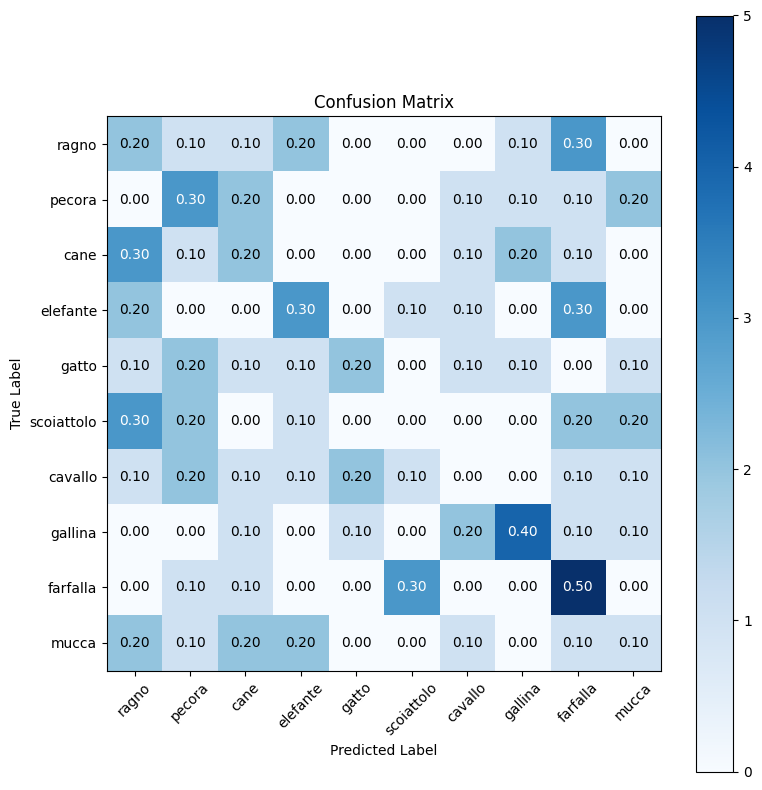

In [ ]:
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = final_model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())


cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)


cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
class AnimalClassifierWithDropout(nn.Module):
    def __init__(self, dropout_rate=0.5, input_size=(128, 128)):
        super(AnimalClassifierWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)


        out_size = self.calc_output_size(input_size[0])
        self.fc1 = nn.Linear(256 * out_size * out_size, 512)
        self.fc2 = nn.Linear(512, 10)

    def calc_output_size(self, size):
        for _ in range(3):
            size = (size - 3 + 2 * 1) // 1 + 1
            size = (size - 2) // 2 + 1
        return size

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.dropout(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.pool(self.relu(self.bn5(self.conv5(x))))
        x = self.dropout(x)
        x = self.relu(self.bn6(self.conv6(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


Training and evaluating model with dropout rate: 0.01
Epoch 1/100, Training Loss: 18.0220, Training Accuracy: 0.0940, Validation Loss: 2.6812, Validation Accuracy: 0.1000
Epoch 2/100, Training Loss: 7.4733, Training Accuracy: 0.1340, Validation Loss: 2.4572, Validation Accuracy: 0.1000
Epoch 3/100, Training Loss: 3.8167, Training Accuracy: 0.1540, Validation Loss: 2.3161, Validation Accuracy: 0.1200
Epoch 4/100, Training Loss: 2.4452, Training Accuracy: 0.1620, Validation Loss: 2.3239, Validation Accuracy: 0.1000
Epoch 5/100, Training Loss: 2.2372, Training Accuracy: 0.1440, Validation Loss: 2.4173, Validation Accuracy: 0.1300
Epoch 6/100, Training Loss: 2.1937, Training Accuracy: 0.1720, Validation Loss: 2.3020, Validation Accuracy: 0.1200
Epoch 7/100, Training Loss: 2.1431, Training Accuracy: 0.1960, Validation Loss: 2.2827, Validation Accuracy: 0.1300
Epoch 8/100, Training Loss: 2.0940, Training Accuracy: 0.2240, Validation Loss: 2.3036, Validation Accuracy: 0.1800
Epoch 9/100, Trai

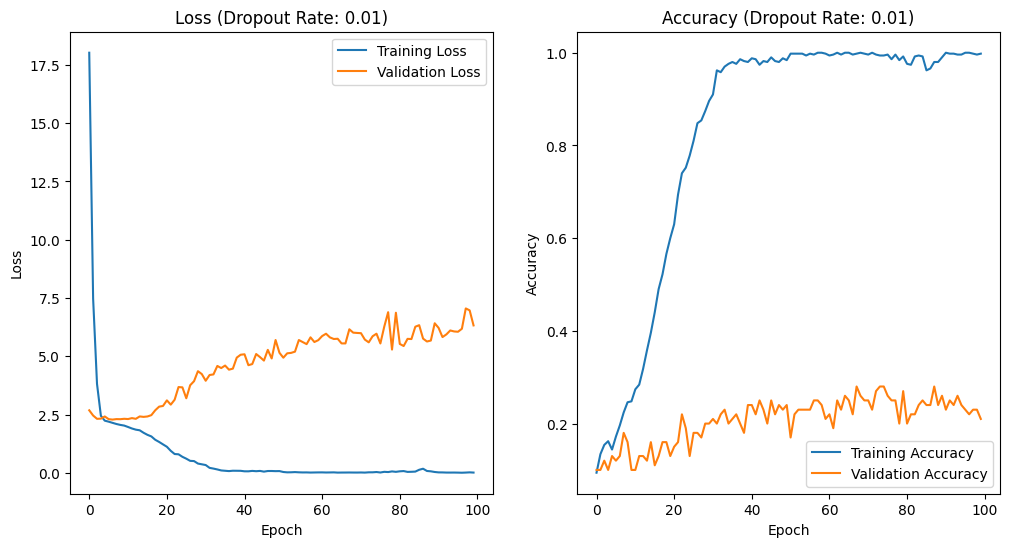

Training and evaluating model with dropout rate: 0.1
Epoch 1/100, Training Loss: 19.4566, Training Accuracy: 0.1120, Validation Loss: 10.9056, Validation Accuracy: 0.1000
Epoch 2/100, Training Loss: 8.1685, Training Accuracy: 0.1320, Validation Loss: 2.4763, Validation Accuracy: 0.1200
Epoch 3/100, Training Loss: 2.8326, Training Accuracy: 0.1300, Validation Loss: 2.2888, Validation Accuracy: 0.1100
Epoch 4/100, Training Loss: 2.3119, Training Accuracy: 0.1400, Validation Loss: 2.2883, Validation Accuracy: 0.1000
Epoch 5/100, Training Loss: 2.2258, Training Accuracy: 0.1780, Validation Loss: 2.2934, Validation Accuracy: 0.1100
Epoch 6/100, Training Loss: 2.1617, Training Accuracy: 0.1980, Validation Loss: 2.2663, Validation Accuracy: 0.1200
Epoch 7/100, Training Loss: 2.1162, Training Accuracy: 0.2180, Validation Loss: 2.3008, Validation Accuracy: 0.1600
Epoch 8/100, Training Loss: 2.0562, Training Accuracy: 0.2460, Validation Loss: 2.3096, Validation Accuracy: 0.1200
Epoch 9/100, Trai

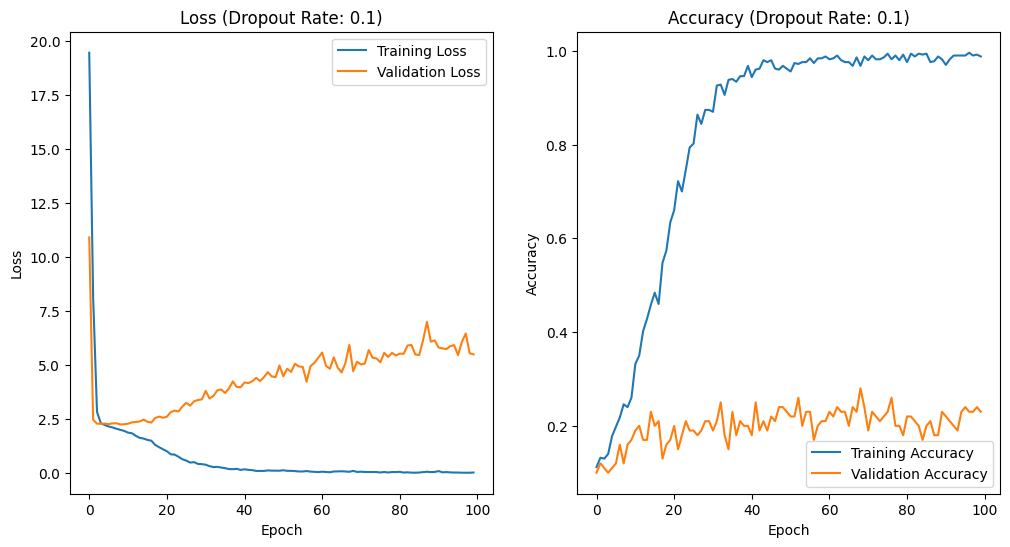

Training and evaluating model with dropout rate: 0.25
Epoch 1/100, Training Loss: 14.4363, Training Accuracy: 0.1060, Validation Loss: 5.1288, Validation Accuracy: 0.1000
Epoch 2/100, Training Loss: 7.1068, Training Accuracy: 0.1040, Validation Loss: 3.1108, Validation Accuracy: 0.1400
Epoch 3/100, Training Loss: 3.0154, Training Accuracy: 0.1880, Validation Loss: 2.6714, Validation Accuracy: 0.1000
Epoch 4/100, Training Loss: 2.3263, Training Accuracy: 0.1860, Validation Loss: 2.3774, Validation Accuracy: 0.0900
Epoch 5/100, Training Loss: 2.1474, Training Accuracy: 0.2040, Validation Loss: 2.4855, Validation Accuracy: 0.1500
Epoch 6/100, Training Loss: 2.0944, Training Accuracy: 0.2120, Validation Loss: 2.4951, Validation Accuracy: 0.1300
Epoch 7/100, Training Loss: 2.0757, Training Accuracy: 0.2280, Validation Loss: 2.5775, Validation Accuracy: 0.1600
Epoch 8/100, Training Loss: 1.9921, Training Accuracy: 0.2480, Validation Loss: 2.4864, Validation Accuracy: 0.1400
Epoch 9/100, Trai

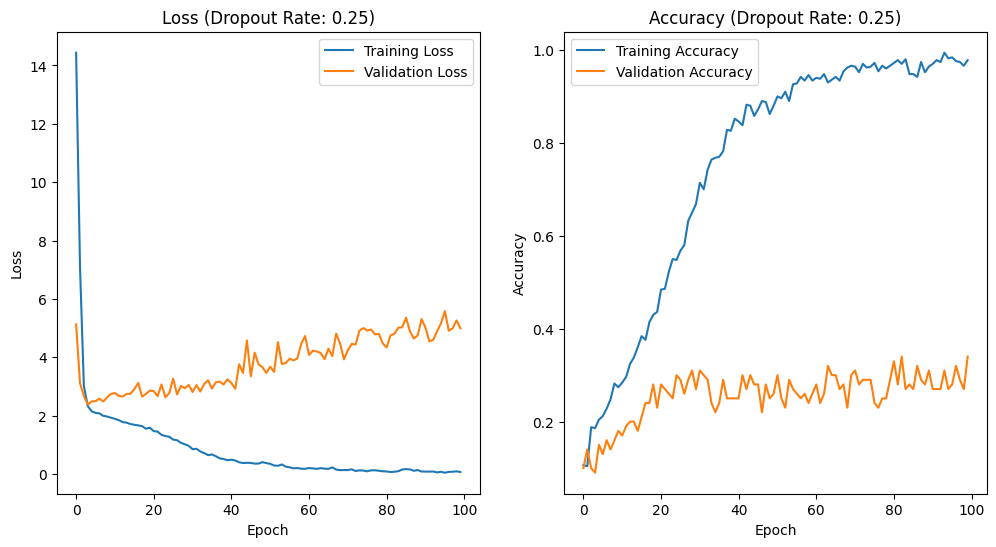

Training and evaluating model with dropout rate: 0.5
Epoch 1/100, Training Loss: 14.5925, Training Accuracy: 0.0960, Validation Loss: 3.3054, Validation Accuracy: 0.1000
Epoch 2/100, Training Loss: 5.8933, Training Accuracy: 0.0780, Validation Loss: 3.1575, Validation Accuracy: 0.1800
Epoch 3/100, Training Loss: 2.3108, Training Accuracy: 0.1240, Validation Loss: 2.6310, Validation Accuracy: 0.1200
Epoch 4/100, Training Loss: 2.3043, Training Accuracy: 0.1300, Validation Loss: 2.4313, Validation Accuracy: 0.0900
Epoch 5/100, Training Loss: 2.2737, Training Accuracy: 0.1320, Validation Loss: 2.4009, Validation Accuracy: 0.1300
Epoch 6/100, Training Loss: 2.2659, Training Accuracy: 0.1340, Validation Loss: 2.3947, Validation Accuracy: 0.0900
Epoch 7/100, Training Loss: 2.2471, Training Accuracy: 0.1240, Validation Loss: 2.4062, Validation Accuracy: 0.1300
Epoch 8/100, Training Loss: 2.2597, Training Accuracy: 0.1400, Validation Loss: 2.3747, Validation Accuracy: 0.1200
Epoch 9/100, Train

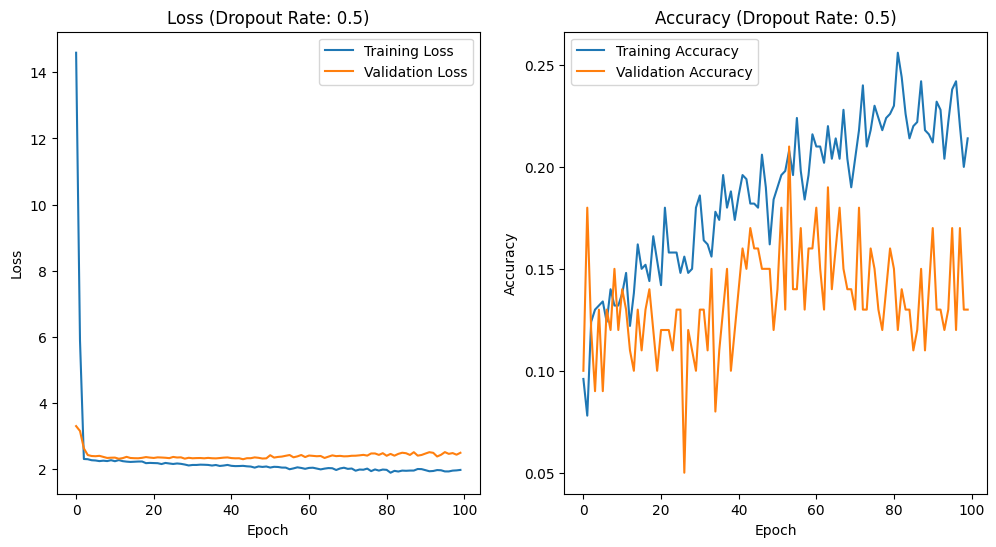

Best Dropout Model Information: {'state_dict': OrderedDict([('conv1.weight', tensor([[[[ 0.1341,  0.0530, -0.0569],
          [ 0.1558,  0.0491,  0.0927],
          [ 0.1682, -0.1479, -0.0084]],

         [[-0.0484,  0.1334, -0.1153],
          [-0.1913,  0.1104,  0.1528],
          [-0.1587, -0.0287, -0.0725]],

         [[-0.1893,  0.0553, -0.1082],
          [ 0.1340,  0.0579,  0.0075],
          [-0.0925, -0.0529, -0.1742]]],


        [[[ 0.0362,  0.0818, -0.1857],
          [ 0.0315,  0.0511,  0.0652],
          [-0.1127,  0.0512, -0.1315]],

         [[ 0.1539,  0.0521, -0.0683],
          [-0.0207, -0.1805, -0.0064],
          [ 0.0075, -0.0690,  0.1428]],

         [[ 0.0968,  0.0449,  0.0679],
          [-0.0172,  0.0049,  0.0519],
          [ 0.0128, -0.1813,  0.0389]]],


        [[[-0.1245,  0.1712,  0.1098],
          [ 0.0937, -0.1215,  0.1031],
          [ 0.0357, -0.0309,  0.1290]],

         [[-0.0140,  0.0852,  0.1303],
          [-0.0314, -0.0399, -0.1872],
        

In [ ]:
import matplotlib.pyplot as plt

def train_dropout_model(train_loader, valid_loader, test_loader, best_model_info, dropout_rates, num_epochs=100):
    best_dropout_accuracy = 0
    best_dropout_model_info = {}

    def evaluate_model(model, criterion, loader):
        model.eval()
        total_correct = 0
        total_samples = 0
        total_loss = 0.0

        with torch.no_grad():
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                total_correct += (predicted == labels).sum().item()
                total_samples += labels.size(0)
                total_loss += loss.item()

        average_loss = total_loss / len(loader)
        accuracy = total_correct / total_samples
        return average_loss, accuracy

    def train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs):
        model.to(device)
        best_accuracy = 0
        best_model = None
        training_losses = []
        training_accuracies = []
        validation_losses = []
        validation_accuracies = []

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            running_accuracy = 0.0
            total_samples = 0
            total_batches = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                running_accuracy += (predicted == labels).sum().item()
                total_samples += labels.size(0)
                total_batches += 1

            epoch_loss = running_loss / total_batches
            epoch_accuracy = running_accuracy / total_samples
            training_losses.append(epoch_loss)
            training_accuracies.append(epoch_accuracy)

            model.eval()
            valid_loss = 0.0
            correct_valid = 0
            total_valid = 0
            with torch.no_grad():
                for inputs, labels in valid_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    valid_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    correct_valid += (predicted == labels).sum().item()
                    total_valid += labels.size(0)

            val_loss = valid_loss / len(valid_loader)
            val_accuracy = correct_valid / total_valid
            validation_losses.append(val_loss)
            validation_accuracies.append(val_accuracy)

            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_model = model.state_dict()

            print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        return best_model, best_accuracy, training_losses, training_accuracies, validation_losses, validation_accuracies

    for dr in dropout_rates:
        print(f"Training and evaluating model with dropout rate: {dr}")
        model = AnimalClassifierWithDropout(dropout_rate=dr, input_size=(128, 128))
        optimizer = optim.Adam(model.parameters(), lr=best_model_info['params']['learning_rate'])
        criterion = nn.CrossEntropyLoss()

        best_dropout_model, val_accuracy, training_losses, training_accuracies, validation_losses, validation_accuracies = train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs)

        valid_loss, val_accuracy = evaluate_model(model, criterion, valid_loader)
        test_loss, test_accuracy = evaluate_model(model, criterion, test_loader)

        print(f"Dropout Rate: {dr}, Validation Accuracy: {val_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

        if val_accuracy > best_dropout_accuracy:
            best_dropout_accuracy = val_accuracy
            best_dropout_model_info = {
                'state_dict': best_dropout_model,
                'dropout_rate': dr,
                'validation_accuracy': val_accuracy,
                'test_accuracy': test_accuracy
            }


        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(training_losses, label='Training Loss')
        plt.plot(validation_losses, label='Validation Loss')
        plt.title(f'Loss (Dropout Rate: {dr})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()


        plt.subplot(1, 2, 2)
        plt.plot(training_accuracies, label='Training Accuracy')
        plt.plot(validation_accuracies, label='Validation Accuracy')
        plt.title(f'Accuracy (Dropout Rate: {dr})')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

    print("Best Dropout Model Information:", best_dropout_model_info)

    return best_dropout_model_info

dropout_rates = [0.01, 0.1, 0.25, 0.5]
best_dropout_model_info = train_dropout_model(train_loader, valid_loader, test_loader, best_model_info, dropout_rates, num_epochs=100)


In [ ]:
print("Best model withouth dropout info: ", best_model_info['params'], "Best model withouth dropout  validation accuracy: ", best_model_info['accuracy'])

Best model withouth dropout info:  {'batch_size': 32, 'learning_rate': 0.001, 'epoch': 89} Best model withouth dropout  validation accuracy:  0.24


In [ ]:
print("Best model dropout rate: ", best_dropout_model_info['dropout_rate'], " Best model validation accuracy: ", best_dropout_model_info['validation_accuracy'], " Best model test accuracy: ", best_dropout_model_info['test_accuracy'])

Best model dropout rate:  0.25  Best model validation accuracy:  0.34  Best model test accuracy:  0.32


## Part2

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt


In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root='/content/split/train', transform=transform)
valid_dataset = datasets.ImageFolder(root='/content/split/valid', transform=transform)
test_dataset = datasets.ImageFolder(root='/content/split/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

classes = train_dataset.classes


In [ ]:
def efficientnet(num_classes, train_fc_only=True, train_last_two_blocks=False):
    model = models.efficientnet_b0(pretrained=True)


    for param in model.parameters():
        param.requires_grad = False

    if train_last_two_blocks:

        for layer in [model.features[-1], model.features[-2]]:
            for param in layer.parameters():
                param.requires_grad = True
    elif train_fc_only:

        for param in model.classifier.parameters():
            param.requires_grad = True


    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(model.classifier[1].in_features, num_classes)
    )

    return model


In [ ]:
def train_efficientnet(model, criterion, optimizer, train_loader, valid_loader, num_epochs=10):
    best_val_accuracy = 0
    best_model_weights = None
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, running_corrects = 0.0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy.item())


        model.eval()
        running_loss, running_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)

        val_loss = running_loss / len(valid_loader.dataset)
        val_accuracy = running_corrects.double() / len(valid_loader.dataset)
        valid_losses.append(val_loss)
        valid_accuracies.append(val_accuracy.item())

        print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_weights = model.state_dict()

    model.load_state_dict(best_model_weights)
    return model, best_val_accuracy.item(), train_losses, train_accuracies, valid_losses, valid_accuracies


In [ ]:
def evaluate_efficientnet(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)
    return correct.double() / total


In [ ]:
def plot_confusion_matrix(model, loader, classes):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()


In [ ]:
model_fc = efficientnet(len(classes), train_fc_only=True)
model_fc = model_fc.to(device)
optimizer_fc = optim.Adam(model_fc.classifier.parameters(), lr=0.001)

model_fc, val_acc_fc, train_losses_fc, train_accuracies_fc, valid_losses_fc, valid_accuracies_fc = train_efficientnet(
    model_fc, criterion, optimizer_fc, train_loader, valid_loader, num_epochs=100
)

test_acc_fc = evaluate_efficientnet(model_fc, test_loader)
print(f"Validation Accuracy (Train FC Only): {val_acc_fc:.4f}")
print(f"Test Accuracy (Train FC Only): {test_acc_fc:.4f}")


Epoch 1/100 - Train Loss: 2.1186, Train Acc: 0.2440, Val Loss: 1.8496, Val Acc: 0.5700
Epoch 2/100 - Train Loss: 1.5657, Train Acc: 0.6640, Val Loss: 1.5198, Val Acc: 0.6600
Epoch 3/100 - Train Loss: 1.2108, Train Acc: 0.7820, Val Loss: 1.3406, Val Acc: 0.7300
Epoch 4/100 - Train Loss: 1.0119, Train Acc: 0.8040, Val Loss: 1.2270, Val Acc: 0.7300
Epoch 5/100 - Train Loss: 0.8460, Train Acc: 0.8420, Val Loss: 1.1566, Val Acc: 0.7000
Epoch 6/100 - Train Loss: 0.7568, Train Acc: 0.8720, Val Loss: 1.0648, Val Acc: 0.7600
Epoch 7/100 - Train Loss: 0.6295, Train Acc: 0.8840, Val Loss: 1.0505, Val Acc: 0.7500
Epoch 8/100 - Train Loss: 0.5599, Train Acc: 0.9000, Val Loss: 0.9960, Val Acc: 0.7500
Epoch 9/100 - Train Loss: 0.4951, Train Acc: 0.9100, Val Loss: 0.9682, Val Acc: 0.7600
Epoch 10/100 - Train Loss: 0.5487, Train Acc: 0.8740, Val Loss: 0.9447, Val Acc: 0.7700
Epoch 11/100 - Train Loss: 0.4578, Train Acc: 0.9280, Val Loss: 0.9246, Val Acc: 0.7500
Epoch 12/100 - Train Loss: 0.4255, Train 

In [ ]:
model_last_two_conv = efficientnet(len(classes), train_last_two_blocks=True)
model_last_two_conv = model_last_two_conv.to(device)
optimizer_last_two_conv = optim.Adam(
    list(model_last_two_conv.classifier.parameters()) + list(model_last_two_conv.features[-1].parameters()) + list(model_last_two_conv.features[-2].parameters()),
    lr=0.001
)

model_last_two_conv, val_acc_last_two_conv, train_losses_last_two_conv, train_accuracies_last_two_conv, valid_losses_last_two_conv, valid_accuracies_last_two_conv = train_efficientnet(
    model_last_two_conv, criterion, optimizer_last_two_conv, train_loader, valid_loader, num_epochs=100
)

test_acc_last_two_conv = evaluate_efficientnet(model_last_two_conv, test_loader)
print(f"Validation Accuracy (Train Last Two Conv & FC): {val_acc_last_two_conv:.4f}")
print(f"Test Accuracy (Train Last Two Conv & FC): {test_acc_last_two_conv:.4f}")


Epoch 1/100 - Train Loss: 1.6929, Train Acc: 0.4960, Val Loss: 0.8380, Val Acc: 0.7800
Epoch 2/100 - Train Loss: 0.5470, Train Acc: 0.8940, Val Loss: 0.7047, Val Acc: 0.7400
Epoch 3/100 - Train Loss: 0.2152, Train Acc: 0.9520, Val Loss: 0.7130, Val Acc: 0.7800
Epoch 4/100 - Train Loss: 0.1174, Train Acc: 0.9760, Val Loss: 0.7136, Val Acc: 0.7700
Epoch 5/100 - Train Loss: 0.0626, Train Acc: 0.9940, Val Loss: 0.7083, Val Acc: 0.7900
Epoch 6/100 - Train Loss: 0.0537, Train Acc: 0.9860, Val Loss: 0.6885, Val Acc: 0.7600
Epoch 7/100 - Train Loss: 0.0455, Train Acc: 0.9900, Val Loss: 0.7739, Val Acc: 0.7400
Epoch 8/100 - Train Loss: 0.0365, Train Acc: 0.9960, Val Loss: 0.8026, Val Acc: 0.7600
Epoch 9/100 - Train Loss: 0.0267, Train Acc: 0.9940, Val Loss: 0.7908, Val Acc: 0.7800
Epoch 10/100 - Train Loss: 0.0196, Train Acc: 0.9980, Val Loss: 0.8141, Val Acc: 0.7900
Epoch 11/100 - Train Loss: 0.0229, Train Acc: 0.9940, Val Loss: 0.8244, Val Acc: 0.7300
Epoch 12/100 - Train Loss: 0.0168, Train 

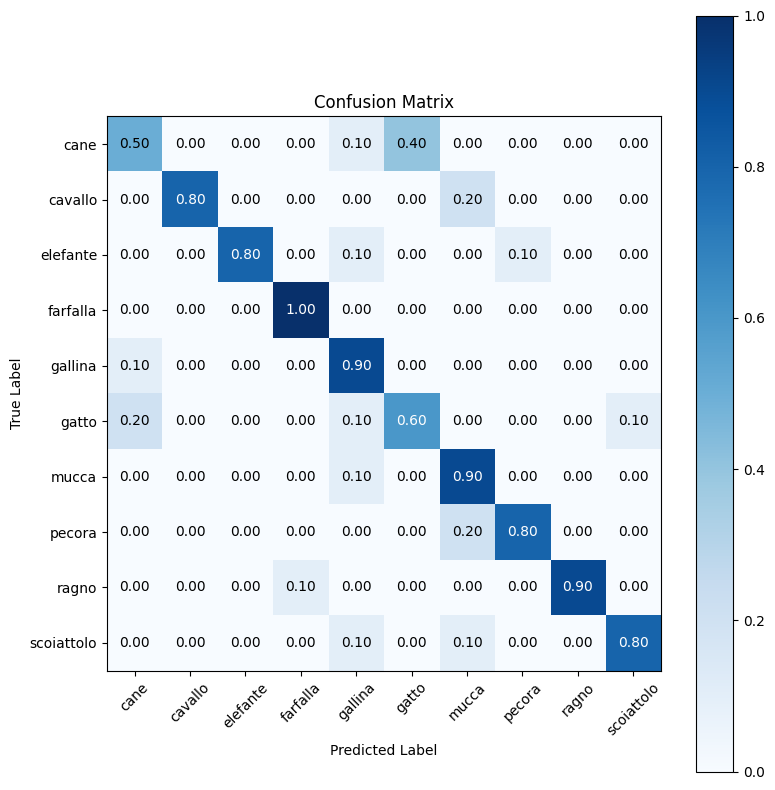

In [ ]:
best_model = model_fc if val_acc_fc > val_acc_last_two_conv else model_last_two_conv
plot_confusion_matrix(best_model, test_loader, classes)
